In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import joblib

from sklearn.svm import SVC, LinearSVC
from imblearn.over_sampling import RandomOverSampler


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, MaxAbsScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score, accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


import thor

In [2]:
train = pd.read_csv('../data/total_train.csv')
test = pd.read_csv('../data/total_test.csv')

X = train['title']
y = train['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

---

# Linear SVM with Count Vectorizer

A **Support Vector Machine** (SVM) is a classifier whose objective is to draw the optimal separating in hyperplane in the feature space. Generally, infinitely many separating hyperplanes exist, so we define the "best separating hyperplane" as the one with **maximal margin**.

The key idea behind SVMs is that the optimal separating hyperplane (the optimization objective) ONLY DEPENDS ON A FEW of the data points and NOT the entire training set! Think about it: to draw a separating hyper plane, you only care about the points "at the boundary" of the separation. These data points are called the **support vectors**.
- Since the optimization objective for SVMs only depend on the support vectors and not the entire data set, this makes SVMs much more resistant to overfitting and very well-suited to deal with high dimensional feature spaces (such as our count encoding of text data).
- However, if we start using kernels, SVMs train very slowly for large data sets. This will be a problem especially with 80,000 training examples. For this reason, we will train a Linear SVM for the imbalanced 80,000 point set, and train a SVM with rbf kernel for a more reasonable 20,000 point set with balanced classes.

In [3]:
# instantiate pipeline for linear SVM
pipe = Pipeline([
            ('cvec', CountVectorizer(max_df=0.3, ngram_range=(1,3), binary=True)),
            ('svm', LinearSVC(max_iter=20_000))
        ])

# fit model
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(binary=True, max_df=0.3, ngram_range=(1, 3))),
                ('svm', LinearSVC(max_iter=20000))])

In [4]:
# score for validation
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9999170078565895, 0.9281712934146645)

- The scores seem on par with Naive Bayes and Logistic Regression.

In [7]:
# do a proper grid search
pipe1 = Pipeline([
            ('cvec', CountVectorizer()),
            ('svm', LinearSVC(max_iter=10_000))
        ])

svm1_params = {
        'cvec__stop_words':[None],
        'cvec__max_df':[0.25, 0.3],
        'cvec__ngram_range':[(1,2), (1,3)],
        'cvec__binary':[True, False],
        'svm__C':[1, 0.1]
        }

In [8]:
# fit model and save

# svm1 = GridSearchCV(pipe1, svm1_params, cv=5, n_jobs=8)

# svm1.fit(X_train, y_train)

# joblib.dump(svm1, '../models/svm1.pkl')

svm1 = joblib.load('../models/svm1.pkl')

In [9]:
# check scores
svm1.score(X_train, y_train), svm1.score(X_test, y_test)

(0.9966803142635831, 0.933150753143284)

In [10]:
print(svm1.best_params_)
print(svm1.best_score_)

{'cvec__binary': True, 'cvec__max_df': 0.3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'svm__C': 0.1}
0.9309090214262545


C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Accuracy:  0.933150753143284
 
Recall:  0.5436702649656526
 
Precision:  0.8849840255591054
 
F1:  0.6735562310030395
 


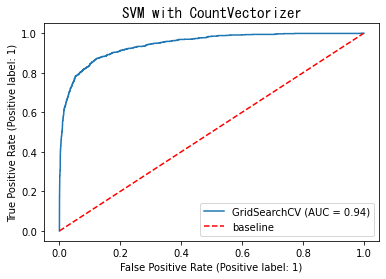

In [11]:
fig, ax = plt.subplots(1, figsize=(6,4));

plot_roc_curve(svm1, X_test, y_test, ax=ax);
plt.plot([0,1],[0,1],linestyle='--', color='red', label='baseline');
plt.title('SVM with CountVectorizer', fontsize=15, font='ms gothic');
plt.legend(loc='lower right');

plt.savefig('../images/svm1-roc.png');

svm1_preds = svm1.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, svm1_preds))
print(" ")
print("Recall: ", recall_score(y_test, svm1_preds))
print(" ")
print("Precision: ", precision_score(y_test, svm1_preds))
print(" ")
print("F1: ", f1_score(y_test, svm1_preds))
print(" ")

---

# Linear SVM with TF-IDF

In [30]:
pipe3 = Pipeline([
            ('cvec', TfidfVectorizer(binary=True)),
            ('svm', LinearSVC(max_iter=10_000))
        ])

svm3_params = {
        'cvec__stop_words':[None],
        'cvec__max_df':[0.3],
        'cvec__ngram_range':[(1,2)],
        'svm__C':[0.5]
        }

In [31]:
# svm3 = GridSearchCV(pipe3, svm3_params, cv=5, n_jobs=8)

# svm3.fit(X_train, y_train)

# joblib.dump(svm3, '../models/svm3.pkl')

svm3 = joblib.load('../models/svm3.pkl')

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', TfidfVectorizer(binary=True)),
                                       ('svm', LinearSVC(max_iter=10000))]),
             n_jobs=8,
             param_grid={'cvec__max_df': [0.3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None], 'svm__C': [0.5]})

In [32]:
print(svm3.best_score_)
print(svm3.best_params_)

svm3.score(X_train, y_train), svm3.score(X_test, y_test)

0.9323890627162778
{'cvec__max_df': 0.3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'svm__C': 0.5}


(0.9929180037623105, 0.9341466450890078)

<br>

- These scores are on par with Logistic Regression. Let's take a look at other metrics.

<br>

C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Accuracy:  0.9327772936636375
 
Recall:  0.5446516192345436
 
Precision:  0.8795562599049128
 
F1:  0.6735562310030395
 


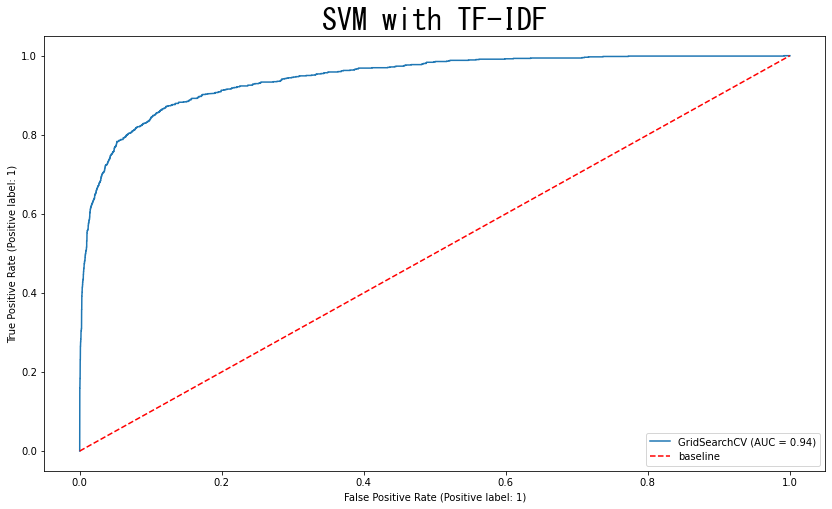

In [23]:
fig, ax = plt.subplots(1, figsize=(14, 8));

plot_roc_curve(svm1, X_test, y_test, ax=ax);
plt.plot([0,1],[0,1],linestyle='--', color='red', label='baseline');
plt.title('SVM with TF-IDF', fontsize=30, font='ms gothic');
plt.legend(loc='lower right');

plt.savefig('../images/svm3-roc.png');

svm3_preds = svm3.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, svm3_preds))
print(" ")
print("Recall: ", recall_score(y_test, svm3_preds))
print(" ")
print("Precision: ", precision_score(y_test, svm3_preds))
print(" ")
print("F1: ", f1_score(y_test, svm1_preds))
print(" ")

<br>

- For the purposes of classifying fake news, we probably want to prioritize Precision over Recall: it seems more costly to mis-identify real news as fake, than it is to mis-identify fake news as real.
- In our case, the SVM model has a slightly higher precision (at the cost of a slightly lower recall) vs the Logistic Regression model. Since the SVM and Logistic Regression have near identical accuracy, we probably prefer the SVM slightly over the Logistic Regression model.

<br>

---

# SVM with RBF/Gaussian Kernel

In this section, we'll implement a SVM with a RBF kernel. Since kernel SVMs generally train very slowly on large data sets, we will restrict ourselves to a more reasonable training set with 20,000 examples. This also provides us with the oppurtunity to explore how balancing out the classes might affect model performance.

<br>

In [38]:
# undersample r/news to create a smaller training set with balanced classes
train = pd.read_csv('../data/total_train.csv')

news_sample_train = train[ train['class'] == 0].iloc[0:10_000]
onion_sample_train = train[ train['class'] == 1].iloc[0:10_000]


balanced_train = pd.concat([news_sample_train, onion_sample_train]).reset_index(drop=True)

X = balanced_train['title']
y = balanced_train['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.5, random_state=42)

In [41]:
# instantiate SVC (rbf kernel is selected by default)
pipe4 = Pipeline([
            ('cvec', TfidfVectorizer(binary=True)),
            ('scale', StandardScaler(with_mean=False)),
            ('svm', SVC(max_iter=10_000))
        ])

svm4_params = {
        'cvec__stop_words':['english'],
        'cvec__max_df':[0.2],
        'cvec__ngram_range':[(1,2)],
        'svm__C':[1]
        }

In [42]:
svm4 = GridSearchCV(pipe4, svm4_params, cv=5, n_jobs=8)

svm4.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', TfidfVectorizer(binary=True)),
                                       ('scale',
                                        StandardScaler(with_mean=False)),
                                       ('svm', SVC(max_iter=10000))]),
             n_jobs=8,
             param_grid={'cvec__max_df': [0.2], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': ['english'], 'svm__C': [1]})

In [43]:
svm4.score(X_train, y_train), svm4.score(X_test, y_test)

(0.9913, 0.7653)

<br>

- With a balanced class, our base line accuracy is 50%.
- The SVM was able to achieve 76.5% accuracy, which is +26.5% over baseline.
- We some severe overfitting, probably a good idea to tweak the hyper parameters and maybe drop stop-words.

Let's take a look at some of the other metrics to round out our evaluation.

<br>

In [44]:
svm4.best_params_

{'cvec__max_df': 0.2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'svm__C': 1}

In [45]:
preds = svm4.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, preds))
print(" ")
print("Recall: ", recall_score(y_test, preds))
print(" ")
print("Precision: ", precision_score(y_test, preds))
print(" ")
print("F1: ", f1_score(y_test, preds))

Accuracy:  0.7653
 
Recall:  0.936
 
Precision:  0.6977784404353661
 
F1:  0.7995216537114548


C:\Users\herma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


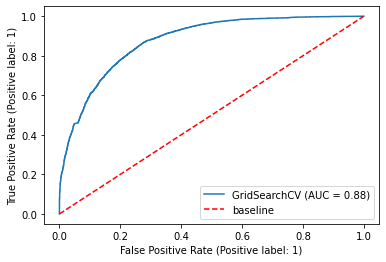

In [46]:
plot_roc_curve(svm4, X_test, y_test);

plt.plot([0,1],[0,1], linestyle='--', color='red', label='baseline');

plt.legend();